# RiskMeasure class examples

In [1]:
import matplotlib.pyplot as plt
from RiskMeasures_Class import RiskMeasures
from RiskMeasures_Class import PortfolioVaR_components
import seaborn as sns
import pandas as pd
sns.set()

/Users/AlessioGiust/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Get Data
df = pd.read_csv("stockdata/stockdata.csv", index_col="Date")
ret = df[["AAPL", "JNJ", "BAC","VWAGY"]].pct_change().dropna()   # dataframe with stock returns
factors = df[["SPY", "DAX"]].pct_change().dropna()               # dataframe with factor returns, used to compute factorial VaR

# Instantiate class (Compute risk measures for all stocks in the df passed in the 'returns' argument)
rm = RiskMeasures(returns=ret, alphas=[0.05, 0.01], weights = [0.25, 0.25, 0.25, 0.25], portfolio=False)

# Compute Risk measures for a portfolio constructed using 'returns' and 'weights'
rm_pf = RiskMeasures(returns=ret, alphas=[0.05], 
                    weights = [0.25, 0.25, 0.25, 0.25],  # weights required if you want to compute VaR/ES for a portfolio constructed using the return series passed in the 'returns' argument
                    portfolio=True)                      # set 'portfolio'=True to compute VaR/ES for a portfolio constructed using the return series passed in the 'returns' argument

## Example 1: get_VaR_basic (same for get_ES_basic)
Available options:
- dist = "gaussian"/"tsduent"/"hist" ---> df = degrees of freedom for the tstudent distribution
- rolling = False (single value for VaR/es) or True (VaR/ES time series) 

If rolling = True you can then set:
- start = datapoint from which you will start to have VaR values
- win = number of datapoints in the rolling window used to computed VaR/ES

In [3]:
var_gauss = rm.get_VaR_basic(dist="gaussian") 
var_gauss  # 95% and 99% VaR for all stocks returns in the 'ret' dataframe

,0.05,0.01
AAPL,0.030076,0.043183
JNJ,0.020166,0.028709
BAC,0.034352,0.049068
VWAGY,0.037891,0.053997


In [4]:
# Rolling VaR
var_gauss_rol = rm.get_VaR_basic(dist="gaussian", rolling=True)  
var_gauss_rol   # first n values are NaN based on 'start' parameter

,AAPL_VaR_0.05,AAPL_VaR_0.01,JNJ_VaR_0.05,JNJ_VaR_0.01,BAC_VaR_0.05,BAC_VaR_0.01,VWAGY_VaR_0.05,VWAGY_VaR_0.01
Date,,,,,,,,
2016-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-09-22,0.029237,0.041786,0.015703,0.022435,0.029835,0.043025,0.051960,0.074629
2021-09-23,0.028929,0.041428,0.015706,0.022438,0.029860,0.043081,0.051918,0.074589
2021-09-24,0.028791,0.041270,0.015633,0.022358,0.029868,0.043172,0.051854,0.074530


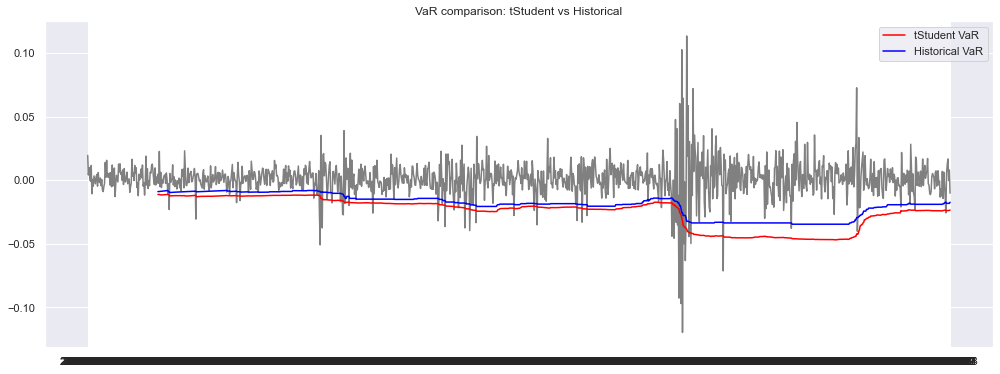

In [5]:
# Rolling VaR for our portfolio (!! set portfolio=True in the class instantiation)
PFret = rm_pf.get_portfolio_returns()   # obtain portfolio returns computed in the class

PFvarT_rol = rm_pf.get_VaR_basic(dist="tstudent", df=6, rolling=True, 
                                start=100, # start computing VaR after the first 100 datapoints
                                win=252)   # use 1-year (252 trading days) rolling window

PFvarH_rol = rm_pf.get_VaR_basic(dist="hist", rolling=True, start=100, win=252)

# Plot VaR comparison with associated portfolio returns
plt.figure(figsize=(17,6))
plt.plot(PFret, "grey")
# use - in VaR to plot it as a loss
plt.plot(-PFvarT_rol, "red", label="tStudent VaR")   # no VaR for first 100 days
plt.plot(-PFvarH_rol, "blue", label="Historical VaR")
plt.title("VaR comparison: tStudent vs Historical")
plt.legend();

## Example 2: get_VaRportfolio_gaussian & get_VaRportfolio_fact (same for ES)
With these function we compute the VaR for a portfolio, starting from the portfolio components return series, not the overall portfolio returns series.
To use this function we must have 'portfolio' = False in our class instantiation and some weights passed.

- get_VaRportfolio_gaussian: computes portfolio VaR using portfolio weights, mean vectors and variance-covariance matrix of the portfolio components, assuming a gaussian distribution for the returns
- get_VaRportfolio_fact: computes portfolio VaR by mapping the portfolio components to the given risk factors ('fact argument'), the underlying returns distribution can be gaussian or tstudent

Both functions accept 'new_w' arguments, which can be used to change the portfolio weights and compare VaR/ES values obtained using different weights.
Other arguments as the previous functions.

In [6]:
# Rolling VaR
PFvargauss = rm.get_VaRportfolio_gaussian(rolling=True, start=252)

PFvarfact = rm.get_VaRportfolio_fact(fact=factors, rolling=True, start=252)   # S&P500 and DAX indexes as risk factors

PFvarfact  # there are n (= number of alphas passed in the class instantiation) columns in the df

,VaR_0.05,VaR_0.01
Date,,
2016-09-30,NaN,NaN
2016-10-04,NaN,NaN
2016-10-05,NaN,NaN
2016-10-06,NaN,NaN
2016-10-07,NaN,NaN
...,...,...
2021-09-22,0.014455,0.021096
2021-09-23,0.014404,0.021041
2021-09-24,0.014315,0.020951


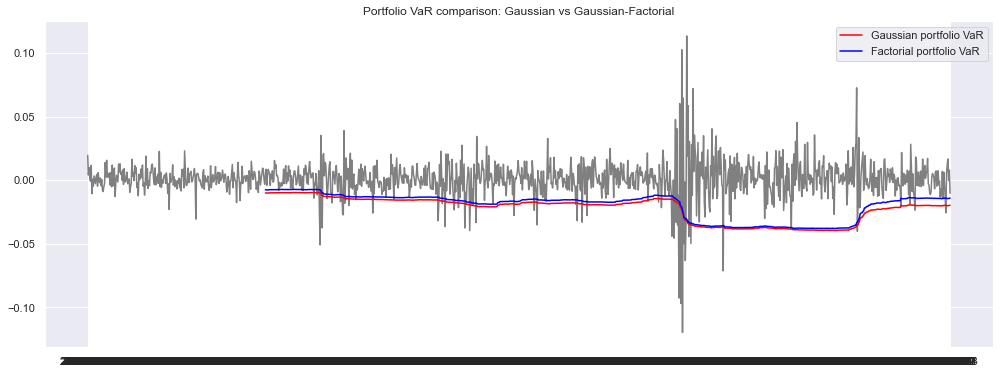

In [7]:
# Plot VaR comparioson with associated portfolio returns 
plt.figure(figsize=(17,6))
plt.plot(PFret, "grey")   # portfolio returns obtained earlier
# use - in VaR to plot it as a loss, select only 95% VaR
plt.plot(-PFvargauss["VaR_0.05"], "red", label="Gaussian portfolio VaR")  
plt.plot(-PFvarfact["VaR_0.05"], "blue", label="Factorial portfolio VaR")
plt.title("Portfolio VaR comparison: Gaussian vs Gaussian-Factorial")
plt.legend();

## Example 3: VaR_Validation
Verify if the theoretical and realized number of exceedances against the VaR are statistically equal.
Statistical test based on normal approximation to the binomial.

- ValueatRisk = series of VaR values obtained from functions defined in this class (first n elememtns are NaN)
- new_r = returns from which the VaR is computed (single stock returns or portfolio returns)
- alpha = alpha level for the passed VaR series
- alpha_test = significance level for validation test
- print_output = if True print test results


In [8]:
# Print output only, the function returns pvalues and zscores
validation = rm.VaR_validation(ValueatRisk=PFvarT_rol, alpha=0.05, new_r=PFret, print_output=True)

---------------------------------------
----- VaR alpha equal to 0.05 -----
Theoretical exceedances: 56.45
Realized exceedances: 44
--> Zscore =  -1.7001
--> pvalue =  0.0891
The VaR is valid
---------------------------------------


## Example 4: Risk_Report

In [9]:
# Risk report for all the stocks in the 'ret' dataframe
df_riskreport = rm.Risk_Report()

df_riskreport

,AAPL,JNJ,BAC,VWAGY
Daily Volatility,0.019232,0.012536,0.021594,0.023632
Daily SemiDeviation,0.014393,0.010301,0.015977,0.016409
Max Rolling Drawdown,-0.221956,-0.138598,-0.42495,-0.44987
Historical_0.95_VaR,0.028557,0.016805,0.029728,0.029432
tStudent_0.95_VaR,0.037196,0.024806,0.042346,0.04664
Historical_0.95_ES,0.044578,0.031196,0.049393,0.050324
tStudent_0.95_ES,0.041756,0.027779,0.047466,0.052243


# Example 5: PortfolioVaR_components subclass
This class allows to compute the following portfolio-VaR-related metrics: 
 - **Marginal VaR**
 - **Component VaR**
 - **Incremental VaR**

We can also use the **VaR_Components_Report** method to obtain all the metrics at once.

This sublcass must be defined with 'portfolio'=True and alphas = [alpha] (list with a single value in it)

In [10]:
# Instantiate the class 
pfrm = PortfolioVaR_components(returns=ret, alphas=[0.01], weights = [0.25, 0.25, 0.25, 0.25], position=1000, portfolio=True)

# Marginal VaR
marginal_report = pfrm.get_marginal_VaR()
marginal_report

,AAPL,JNJ,BAC,VWAGY,Portfolio
Beta,0.985625,0.53837,1.193834,1.282171,NaN
Marginal_VaR,0.031992,0.017475,0.03875,0.041617,NaN
Diversified_VaR,NaN,NaN,NaN,NaN,32.458261


In [11]:
# Component VaR
component_report = pfrm.get_component_VaR()
component_report

,AAPL,JNJ,BAC,VWAGY,Portfolio
Component_VaR,7.99792,4.36864,9.687441,10.404259,32.458261
%_Contribution,0.246406,0.134593,0.298458,0.320543,1.000000


In [12]:
# Incremental VaR with big postions change (expressed as a percentage change)
incremental_report_big = pfrm.get_incremental_VaR(delta_position_pct=0.3)
# Incremental VaR with small postions change (expressed as a percentage change)
incremental_report_small = pfrm.get_incremental_VaR(delta_position_pct=0.02)

# Note how the incremental approximation is precise only for small changes in the overall portfolio value
print(incremental_report_big)
print(incremental_report_small)

                              AAPL        JNJ        BAC      VWAGY
Starting_Portfolio_VaR   32.458261  32.458261  32.458261  32.458261
Approx_Incremental_VaR    9.597504   5.242368  11.624929  12.485111
NewApprox_Portfolio_VaR  42.055765  37.700629   44.08319  44.943372
Exact_Incremental_VaR     10.37271   5.876958  12.552535  13.719716
NewExact_Portfolio_VaR   42.830971  38.335219  45.010795  46.177977
%_VaR_Increment           0.319571   0.181062   0.386729   0.422688
                              AAPL        JNJ        BAC      VWAGY
Starting_Portfolio_VaR   32.458261  32.458261  32.458261  32.458261
Approx_Incremental_VaR    0.639834   0.349491   0.774995   0.832341
NewApprox_Portfolio_VaR  33.098094  32.807752  33.233256  33.290601
Exact_Incremental_VaR     0.634512   0.354714   0.781879    0.84624
NewExact_Portfolio_VaR   33.092772  32.812975  33.240139  33.304501
%_VaR_Increment           0.019549   0.010928   0.024089   0.026072


In [13]:
# Summary report
df_componentsreport = pfrm.VaR_Components_Report(delta_position_pct=0.05)
df_componentsreport

,AAPL,JNJ,BAC,VWAGY,Portfolio
Marginal_VaR,0.031992,0.017475,0.03875,0.041617,NaN
Diversified_VaR,NaN,NaN,NaN,NaN,32.458261
Component_VaR,7.99792,4.36864,9.687441,10.404259,32.458261
%_Contribution,0.246406,0.134593,0.298458,0.320543,1.000000
Exact_Incremental_VaR,1.605341,0.89811,1.973756,2.13974,NaN
New_Portfolio_VaR,34.063602,33.356371,34.432016,34.598001,NaN
%_VaR_Increment,0.049459,0.02767,0.060809,0.065923,NaN
